In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("/content/drive/MyDrive/my projects/breast_cancer_detection/data/data.csv")

In [4]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


(array([212.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 357.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

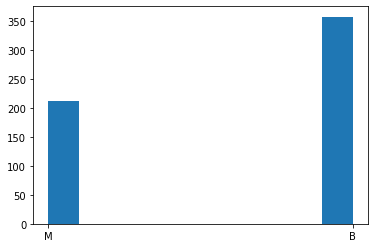

In [15]:
plt.hist(data["diagnosis"])

In [3]:
features=list(data.keys())

In [5]:
features.remove("Unnamed: 32")

In [6]:
id = list(data[features[0]])
Y_list = list(data[features[1]])

In [7]:
def one_hot_for_y(Y_list):
  m = len(Y_list)
  Y = np.zeros((m,1))
  for count,diagnosis in enumerate(Y_list):
    if(diagnosis == "M"):
      Y[count,0] = 1
  return Y


In [8]:
Y=one_hot_for_y(Y_list)

In [9]:
features.remove("diagnosis")
features.remove("id")

In [10]:
def build_X(features,data):
  n = len(features)
  m = len(data[features[0]])
  X = np.zeros((m,n))
  for count,feature in enumerate(features):
    X[:,count] = np.array(list(data[feature]))
  return X

In [11]:
X = build_X(features,data)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)

In [17]:
print(X_train.shape)

(483, 30)


In [28]:
import tensorflow.keras
from tensorflow.keras.layers import Input,Dense,Activation,Dropout,BatchNormalization,Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [46]:
def cancer_model(input_shape):
  X_input = Input(shape=input_shape,dtype='float64')

  X = BatchNormalization()(X_input)

  X = Dense(60,kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.01))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Dropout(rate=0.2)(X)

  X = Dense(120,kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.01))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Dropout(rate=0.2)(X)

  X = Dense(120,kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.01))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Dropout(rate=0.2)(X)

  X = Dense(60,kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.01))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Dense(1,activation='sigmoid',kernel_initializer=glorot_uniform())(X)
  
  model = Model(inputs=X_input,outputs=X)
  return model

In [53]:
model = cancer_model((X.shape[1],))

In [54]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 30)                120       
_________________________________________________________________
dense_19 (Dense)             (None, 60)                1860      
_________________________________________________________________
batch_normalization_17 (Batc (None, 60)                240       
_________________________________________________________________
activation_12 (Activation)   (None, 60)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 120)               7320

In [55]:
earlystopper = EarlyStopping(patience=4,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=1,factor=0.0001)
callback_list = [earlystopper,reduce_lr]

In [56]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [57]:
model.fit(X_train,y_train,validation_split=0.15,callbacks=callback_list,epochs=50)

Epoch 1/50
13/13 [==============================] - 2s 32ms/step - loss: 3.6247 - accuracy: 0.7561 - val_loss: 4.1160 - val_accuracy: 0.3836
Epoch 2/50
13/13 [==============================] - 0s 10ms/step - loss: 3.2163 - accuracy: 0.8976 - val_loss: 4.0274 - val_accuracy: 0.3836
Epoch 3/50
13/13 [==============================] - 0s 10ms/step - loss: 2.9177 - accuracy: 0.9317 - val_loss: 3.7171 - val_accuracy: 0.3836
Epoch 4/50
13/13 [==============================] - 0s 13ms/step - loss: 2.6482 - accuracy: 0.9634 - val_loss: 3.4308 - val_accuracy: 0.3836
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 2.4292 - accuracy: 0.9561 - val_loss: 3.2153 - val_accuracy: 0.3836
Epoch 6/50
13/13 [==============================] - 0s 10ms/step - loss: 2.2139 - accuracy: 0.9463 - val_loss: 2.8207 - val_accuracy: 0.3836
Epoch 7/50
13/13 [==============================] - 0s 11ms/step - loss: 2.0191 - accuracy: 0.9512 - val_loss: 2.5255 - val_accuracy: 0.4384
Epoch 8/50
13

Evaluation on Test Set

In [58]:
test_loss,test_acc=model.evaluate(X_test,y_test,verbose=1)

3/3 [==============================] - 0s 5ms/step - loss: 0.3918 - accuracy: 0.9651


In [62]:
def get_probability(X):
  prediction =( model.predict(X) ) * 100
  print("Probability that you have breast cancer(malignant) is "+str(np.squeeze(prediction)) + " %")
 


In [63]:
my_input = X_test[5,:].reshape(1,30)
get_probability(my_input)

Probability that you have breast cancer(malignant) is 97.091415 %


Testing Model on completely diffrent data

In [97]:
df = pd.read_csv("/content/drive/MyDrive/my projects/breast_cancer_detection/other_site_data.csv")

In [98]:
df.head()

,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [99]:
arr = np.array(df)

In [100]:
y = arr[:,1]

In [102]:
x = arr[:,2:]

In [103]:
y = one_hot_for_y(list(y))

In [105]:
x = x.astype(np.float64)

In [106]:
my_input = x[19,:].reshape(1,30)

In [108]:
test_loss,test_acc=model.evaluate(x,y)

18/18 [==============================] - 0s 3ms/step - loss: 0.3482 - accuracy: 0.9842


In [110]:
print(f"model on completely diffrent data is giving accuracy of {test_acc * 100} %")

model on completely diffrent data is giving accuracy of 98.41549396514893 %
